# Mini-project_Basic submission

# A. Problem formulation


The main problem of this basic project is classifying images from the Yummy Dataset to determine if they contain rice or chips. It's intriguing that given images are taken in diverse settings and angles of the images, indicating the need for substantial image pre-processing before classification. Moreover, the use of a machine learning classification model instead of employing deep learning models like CNN for image data adds more fun to this project.

# B. Machine Learning pipeline


Input of the ML pipeline is the imges in '/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images_small' folder. Output of this pipeline is the label whether it includes 'rice' or 'chips'.


I'll go through various transformation stages prior to implementing classification machine learning models. This includes tasks such as image resizing, pixel normalization, and data augmentation. Subsequently, I'll employ diverse ML models, comprising SVM, LR, NB, and ensemble models.


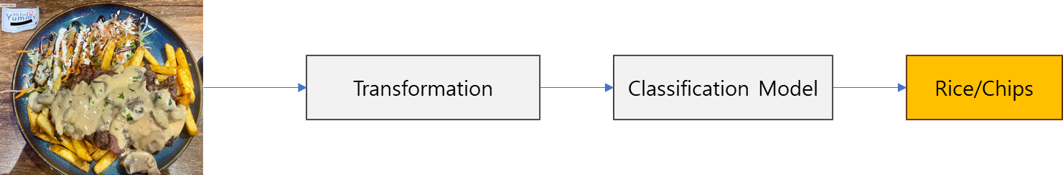

In [ ]:
!pip install mlend > /dev/null
print('Installation completed')

Installation completed


In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import os

import mlend
from mlend import download_yummy_small, yummy_small_load

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')
base_dir = '/content/drive/MyDrive/Data/MLEnd/yummy/'
MLYD_df = pd.read_csv(base_dir+'MLEndYD_image_attributes_small.csv')
MLYD_df[:5] #check the csv file

Mounted at /content/drive


,filename,Dish_name,Home_restaurant,Cuisine,Ingredients,Diet,Healthiness_rating,How_much_did_you_like_it,Rice_Chips,Benchmark_A
0,00001.jpg,steak_&_fries,resturaunt,american,"steak,fries,mixed_salad",non-veg,neutral,strongly_like,chips,Test
1,00002.jpg,beef_burger_meal,restaurant,american,"chips,burger,chicken_nugget",non-veg,unhealthy,like,chips,Train
2,00003.jpg,chicken_burger_with_fries_and_wings,restaurant,american,"fried_chicken_breast,lettuce,ketchup,sesame_se...",non-veg,unhealthy,like,chips,Train
3,00004.jpg,fried_rice_with_curd,home,indian,"rice,onion,potato,tomato,olive_oil,curd",vegetarian,neutral,like,rice,Train
4,00005.jpg,fish_and_chips,tcr_bar,british,"cod,beer,flour,tartare_sauce,peas,oil",vegetarian,neutral,strongly_like,chips,Test


# C. Transformation stage

1) Resizing image data

Transform the images to uniform image size for the computational efficiency and better traininig.

First, I calculated smallest image width and height to decide on the ratio/size of the resized image. I believe checking the smallest height, width is crucial since most of the image data is taken with smartphone which doesn't have a equal size of height and width.

In [ ]:
img_dir= base_dir+'MLEndYD_images_small/' #directory path where the folders with images are located.

def smallest_img_size(path):
    file_list = os.listdir(path)
    sizes = [Image.open(os.path.join(path, file_name)).size for file_name in file_list]
    smallest_width, smallest_height = min(sizes, key=lambda x: (x[0], x[1]))
    return smallest_width, smallest_height

smallest_width, smallest_height = smallest_img_size(img_dir)
print(f"Smallest width: {smallest_width}\nSmallest height: {smallest_height}")


Smallest width: 910
Smallest height: 747


In [ ]:
# Resize the image

new_size = (90,70) #Set the new size image based on the previous findings about the smallest width and height.
#new_size = (90,90) #image size in square size

def resize_img(input, output, size):
  if os.path.exists(output):
    return print("Resized image already exists.")
  os.makedirs(output, exist_ok=True)

  for f in os.listdir(input):
      img = Image.open(os.path.join(input, f))
      img = img.resize(size).convert('RGB')
      img.save(os.path.join(output, f))
  print("Resizing completed.")

resize_dir = base_dir+'resized_img/'
resize_img(img_dir,resize_dir,new_size)

# resize_dir = base_dir+'square_resized_img/'
# resize_img(img_dir,resize_dir,new_size)


Resized image already exists.


2) Normalisation of the pixel value will be done when we transform image to array.

3) Data Augmentation

Since we have only 99 images which are relatively small, applying data augmentation can improve robustness of model and prevent from overfitting.
- Apply random data augmentation

I've created an ImagePreProcessor class capable of applying different kinds of distinct data augmentation techniques to images. This class is designed to randomly combine up to two techniques, offering diverse forms of image preprocessing for enhanced variations in the augmented images.

In [ ]:
import random
import inspect
import cv2
from PIL import Image, ImageEnhance, ImageOps

class ImagePreprocessor:

    def __init__(self,image_path):
      self.image_path = image_path

    def random_augment(self,image):
        functions = {'Color': self.color,
                      'Rotate': self.rotate,
                      'Identity': self.identity,
                      'ShearX': self.shear_x,
                      'ShearY': self.shear_y,
                      'TranslateX': self.translate_x,
                      'TranslateY': self.translate_y
                     }

        available_ops = ['Color','Rotate', 'Identity','ShearY', 'TranslateX','TranslateY']

        #Apply data augmentation
        select = 2 #Fixed 'select' option to apply up to two data augmentation
        for op_name in random.sample(available_ops,select):
          func, args = self.put_args(op_name,functions)
          # print(f"{op_name} applied") #Use this when you want to check which options are applied
          image = func(np.uint8(image),*args)
        return np.array(image)/255 #normalise the pixel value

    def put_args(self, name, functions):
      Func = functions[name]
      args = tuple()

      # Retrieve the signature of the function
      sig = inspect.signature(Func)

      if "factor" in sig.parameters:
          args = tuple(list(args) + [np.random.uniform(0.14, 1.4)])
      if "degrees" in sig.parameters:
          args = tuple(list(args) + [np.random.randint(-5, 5)])
      if "level" in sig.parameters:
          args = tuple(list(args) + [np.random.uniform(-0.1, 0.1)])
      if "pixels" in sig.parameters:
          args = tuple(list(args) + [np.random.uniform(-7.0, 7.0)])

      return (Func, args)

    def color(self,image, factor):
        image = Image.fromarray(image,'RGB')
        image = ImageEnhance.Color(image).enhance(factor)
        return  image

    def rotate(self,image,degrees):
        image = Image.fromarray(image,'RGB')
        image =  image.rotate(angle=degrees)
        return image

    def identity(self,image):
        return image

    def shear_x(self,image, level):
        image = Image.fromarray(image,'RGB')
        image=image.transform(image.size, Image.AFFINE, (1, level, 0, 0, 1, 0), Image.BICUBIC)
        return image

    def shear_y(self,image, level):
        image = Image.fromarray(image,'RGB')
        image=image.transform(image.size, Image.AFFINE, (1, 0, 0,level,  1, 0), Image.BICUBIC)
        return image

    def translate_x(self,image, pixels):
        image = Image.fromarray(image,'RGB')
        image=image.transform(image.size, Image.AFFINE, (1, 0,pixels, 0, 1, 0))
        return image

    def translate_y(self,image, pixels):
        image = Image.fromarray(image,'RGB')
        image=image.transform(image.size, Image.AFFINE, (1, 0, 0, 0, 1, pixels))
        return image

    def load_image(self, image_id):
        image = cv2.imread(self.image_path + '/'+image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

Visualize the results of data augmentation ! Let's compare with the original image.

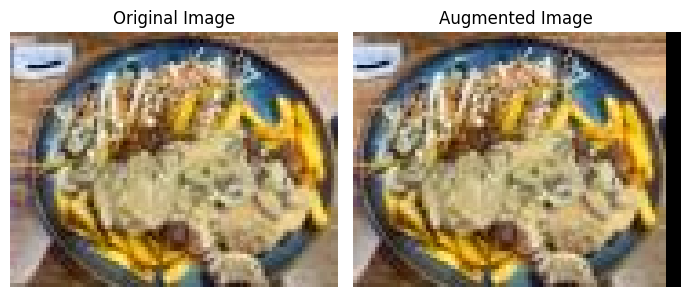

In [ ]:
preprocessor = ImagePreprocessor(resize_dir)
image = preprocessor.load_image('00001.jpg')
img_path = resize_dir + '/00001.jpg'
original_img = Image.open(img_path)

fig, axs = plt.subplots(1, 2, figsize=(7, 5))

axs[0].imshow(original_img)
axs[0].axis('off')
axs[0].set_title('Original Image')

augmented_img = preprocessor.random_augment(original_img)
axs[1].imshow(augmented_img)
axs[1].axis('off')
axs[1].set_title('Augmented Image')

plt.tight_layout()
plt.show()

I will apply this data augmentation to the training dataset at part6.Methodology part.

### Feature Extraction ideas 💡

This section includes various ideations and experiments on feature extraction centering on the question

#### 'How can I effectively extract the food information from the image?'

Feature extraction is critical in reducing computational complexity and delivering relevant information to the model filtering noise of the data.


1) Remove the background with too dark/light background

This attempt is based on the assumption that overly dark or too light area image would be irrelevant from the food area we are interested in.

=> Successfully separated white dish from food in some cases, but had a critical issue with removing white rice


In [ ]:
import cv2
import os
import numpy as np
from PIL import Image

In [ ]:
def remove_dark_light(image, tolerance=100):
    img_path = os.path.join(resize_dir, image)
    original_img = Image.open(img_path)
    img_array = np.array(original_img)

    #Define threshold of dark and light regions
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([tolerance, tolerance, tolerance])

    lower_white = np.array([255 - tolerance, 255 - tolerance, 255 - tolerance])
    upper_white = np.array([255, 255, 255])

    mask_black = cv2.inRange(img_array, lower_black, upper_black) #to filter dark areas
    mask_white = cv2.inRange(img_array, lower_white, upper_white) #to filter light area

    black_white_mask  = cv2.bitwise_or(mask_black, mask_white)
    mask = cv2.bitwise_not(black_white_mask)

    result = cv2.bitwise_and(img_array, img_array, mask=mask)

    return original_img,Image.fromarray(result)

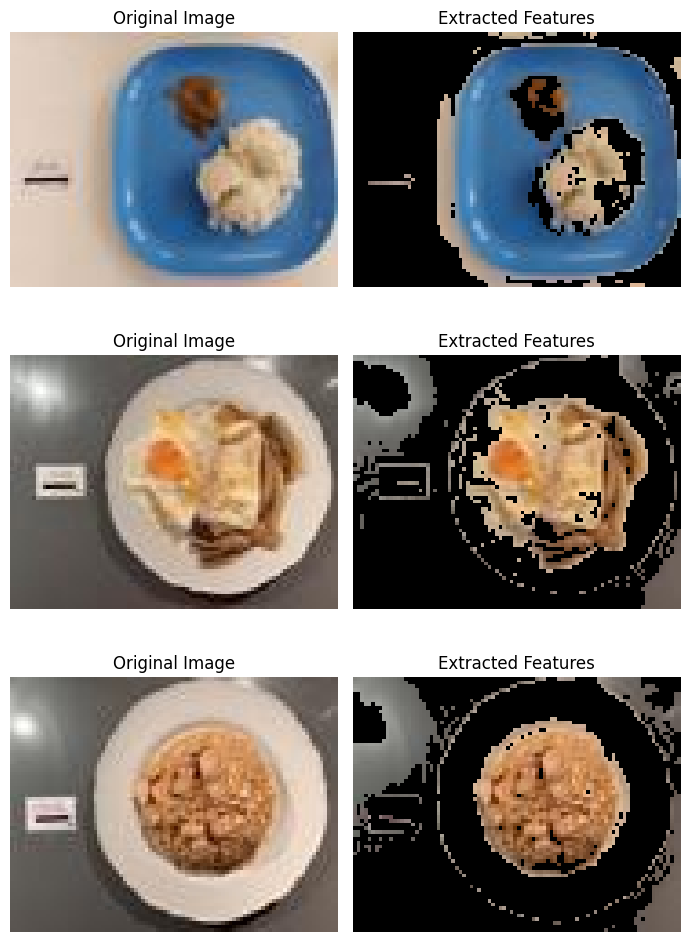

In [ ]:
image_files = os.listdir(resize_dir+'/')
random_images = ['00023.jpg', '00006.jpg', '00065.jpg'] #Fixed images to effectively demonstrate the point
fig, axs = plt.subplots(3, 2, figsize=(7, 10))

for idx, image in enumerate(random_images):
    original, extracted =remove_dark_light(image)
    axs[idx, 0].imshow(original)
    axs[idx, 0].axis('off')
    axs[idx, 0].set_title('Original Image')

    axs[idx, 1].imshow(extracted)
    axs[idx, 1].axis('off')
    axs[idx, 1].set_title('Extracted Features')

plt.tight_layout()
plt.show()


3) Retrieve the food area from YOLO Model bounding box

I attempted to retrieve the bounding box area and crop the food area using Yolov3 pre-trained object detection on coco dataset. However, COCO dataset lacks food object diversity, and its 'bowl' label doesn't accurately capture the variety of food dishes in our dataset. Furthermore, YOLOv3's complexity makes fine-tuning to our dataset challenging, and its computational cost expensive for feature extraction. So, I decided not to apply Yolov3 for the feature extraction.

3) Saturation based food separation

This idea is based on the idea that the food area will have a higher saturation showing higher intensity on color. To test if it is possible to separate the food with saturation, I increased saturation and created bounding box to isolate food area part.

In [ ]:
def saturation_test(image_path, saturation_factor=1.5):
    img = cv2.imread(os.path.join(resize_dir, image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #BGR->RGB
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV) #RGB->HSV

    h, s, v = cv2.split(img_hsv)
    increased_saturation = np.where(s * saturation_factor <= 255, s * saturation_factor, 255)
    modified_hsv = cv2.merge((h, increased_saturation.astype(np.uint8), v)) #  Merge HSV back
    modified_bgr = cv2.cvtColor(modified_hsv, cv2.COLOR_HSV2BGR) #HSV->BGR

    mean_saturation = np.mean(increased_saturation)
    _, thresh = cv2.threshold(increased_saturation.astype(np.uint8), mean_saturation, 255, cv2.THRESH_BINARY)

    # Find contours of potential food areas
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contour_area_threshold = 1000  # Filter the contour area
    for contour in contours:
      area = cv2.contourArea(contour)
      if area > contour_area_threshold:
          x, y, w, h = cv2.boundingRect(contour)
          cv2.rectangle(modified_bgr, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return img_rgb, modified_bgr

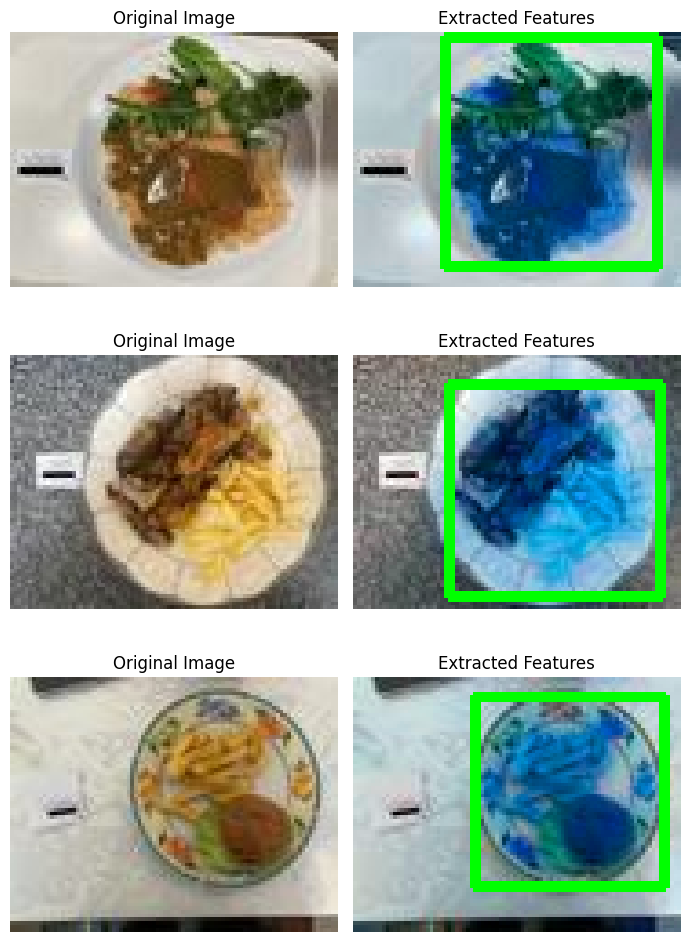

In [ ]:
#Fixed random images to demonstrate the success cases
random_images = ['00095.jpg', '00029.jpg', '00072.jpg']
fig, axs = plt.subplots(3, 2, figsize=(7, 10))

for idx, image in enumerate(random_images):
    original, extracted = saturation_test(image)
    axs[idx, 0].imshow(original)
    axs[idx, 0].axis('off')
    axs[idx, 0].set_title('Original Image')

    axs[idx, 1].imshow(extracted)
    axs[idx, 1].axis('off')
    axs[idx, 1].set_title('Extracted Features')

plt.tight_layout()
plt.show()


Randomly sampled image shows that the hypothesis that 'food area will have a higher saturation' is likely be truth. Now, I made improved function separate_food to crop the food area based on the saturation function at the previous section.

In [ ]:
def separate_food(image_path, saturation_factor=1.5):
    img = cv2.imread(os.path.join(resize_dir, image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR -> RGB
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV) # RGB -> HSV

    h, s, v = cv2.split(img_hsv) # separate h, s, v

    # Increase saturation for areas with potential food items
    increased_saturation = np.where(s * saturation_factor <= 255, s * saturation_factor, 255)
    modified_hsv = cv2.merge((h, increased_saturation.astype(np.uint8), v))
    modified_bgr = cv2.cvtColor(modified_hsv, cv2.COLOR_HSV2BGR) # HSV -> BGR

    # Adaptive thresholding to identify potential food areas
    adaptive_thresh = cv2.adaptiveThreshold(increased_saturation.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    # Find contours of potential food areas
    contours, _ = cv2.findContours(adaptive_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rectangles = []

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 1000:  # Filter contour area
            x, y, w, h = cv2.boundingRect(contour)
            rectangles.append((x, y, w, h))

    if not rectangles:
        return img_rgb, img_rgb

    mask = np.zeros_like(img_rgb)
    for x, y, w, h in rectangles:
        cv2.rectangle(mask, (x, y), (x + w, y + h), (255, 255, 255), -1)  #Create mask for rectangles

    # Apply the mask to black out area outside rectangle
    result = cv2.bitwise_and(img_rgb, mask)

    # Calculate the overall bounding box
    x_min = min([x for x, _, _, _ in rectangles])
    y_min = min([y for _, y, _, _ in rectangles])
    x_max = max([x + w for x, _, w, _ in rectangles])
    y_max = max([y + h for _, y, _, h in rectangles])

    # Crop the image based on the final bounding box
    cropped_result = result[y_min:y_max, x_min:x_max]

    #Ensure the image size is not changed.
    cropped_resized = cv2.resize(cropped_result, (90, 70))

    return img_rgb, Image.fromarray(cropped_resized)


< Saturation based food separation - Success case >


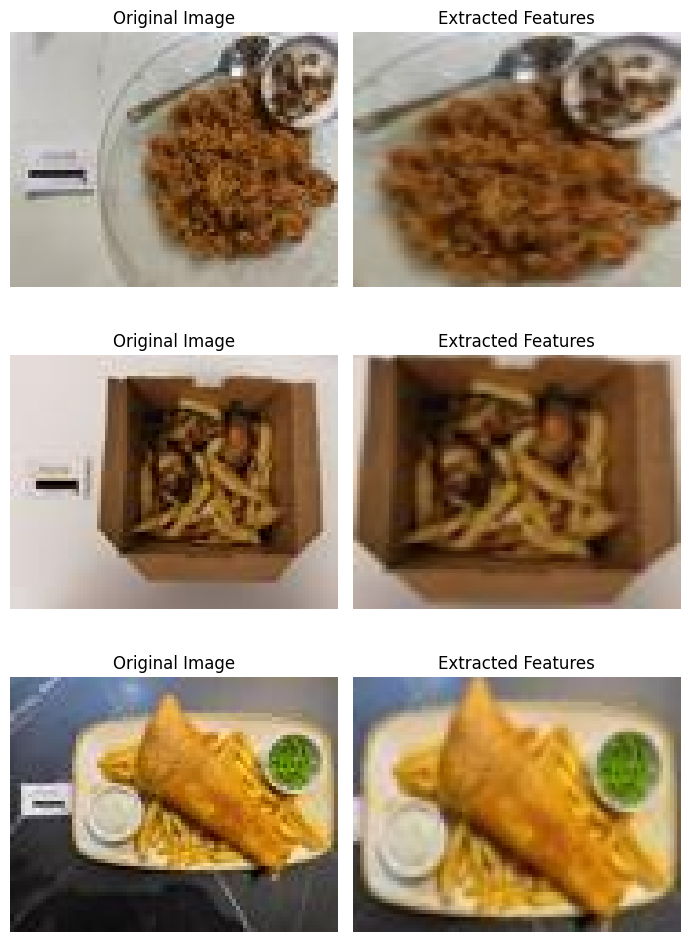

In [ ]:
random_images = ['00004.jpg','00068.jpg','00005.jpg']
fig, axs = plt.subplots(3, 2, figsize=(7, 10))

for idx, image in enumerate(random_images):
    original, extracted = separate_food(image)
    axs[idx, 0].imshow(original)
    axs[idx, 0].axis('off')
    axs[idx, 0].set_title('Original Image')

    axs[idx, 1].imshow(extracted)
    axs[idx, 1].axis('off')
    axs[idx, 1].set_title('Extracted Features')

plt.tight_layout()
plt.show()


< Saturation based food separation - Edge case >

Food separation worked well on most of the cases , but the edges cases below showed unsuccessful food separation.

- Image with colorful pattern/background
- Image with scattered objects
- Image with colorful background & less intensive food saturation

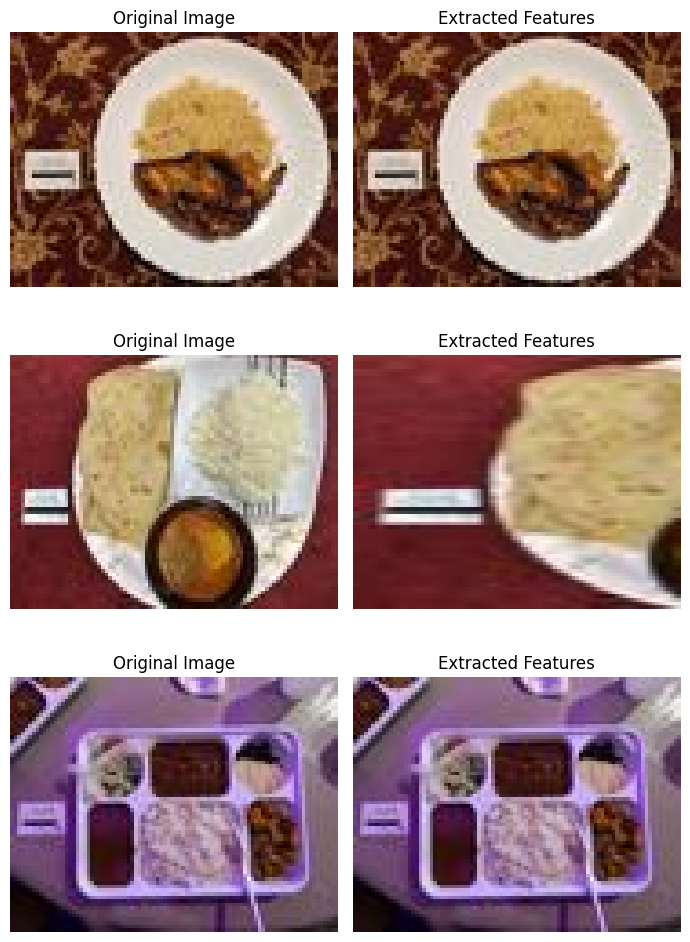

In [ ]:
#Fixed random images to demonstrate the edge cases
random_images = ['00022.jpg', '00030.jpg', '00034.jpg']
fig, axs = plt.subplots(3, 2, figsize=(7, 10))

for idx, image in enumerate(random_images):
    original, extracted = separate_food(image)
    axs[idx, 0].imshow(original)
    axs[idx, 0].axis('off')
    axs[idx, 0].set_title('Original Image')

    axs[idx, 1].imshow(extracted)
    axs[idx, 1].axis('off')
    axs[idx, 1].set_title('Extracted Features')

plt.tight_layout()
plt.show()


# D. Modelling


1. Support Vector Machines (SVM):
SVM is well known for its high accuracy and computational efficiency, particularly in small datasets. It has strength in binary classification tasks, effectively finding the optimal hyperplane to separate data points from different classes. Given our dataset of 99 images aimed at classifying 'rice' or 'chips,' SVM aligns well with this task.

4. Logistic Regression (LR):
LR is the most basic and interpretable model for binary classification. For the baseline model, I chose to use LR for this challenge.

5. Naive Bayes (NB):
NB is also very probablistic and interpretable classification model.Similar to LR, I chose this model for the baseline model.

6. CatBoost Classifier:
CatBoostClassifier is a gradient boosting based classifier suitable for handling complex data. I chose this model after conducting research on winning solutions on classification tasks at data science competitions like Kaggle.

6. Ensemble _ Hard Voting: I used ensemble model to enhance the performance and robustness of the model by collecting predictions of multiple models.

# E. Methodology


1) Assess the class distribution

First of all, I will assess the class distribution within the dataset to ensure balance. Based on the distribution analysis, I will decide on the whether I should use the strategy below.

**Resampling**: If there is serious imbalance on the class, oversampling or undersampling may be considered to address the class imbalance issue.

In [ ]:
#Check the label distribution of the data
MLYD_df.Rice_Chips.value_counts()

rice     50
chips    49
Name: Rice_Chips, dtype: int64

Fortunately, our class distribution is very well-balanced that we can skip the resampling of the particular class dataset.


2) Split the dataset  
Once the previous decision is made, I will split the dataset into train/test dataset. I used test_size=0.2 because we have small dataset that allocating big portion(80%) of data to training would be beneficial for the generalisation and training.I made separate 3 versions of training data to experiment which dataset is most suitable for this task.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

MLYD_df = MLYD_df[['filename', 'Rice_Chips']] #Since input is image path, clear rest of the unused features
X = MLYD_df.iloc[:, :-1]
y = MLYD_df.iloc[:, -1]
LE= LabelEncoder()
y = LE.fit_transform(y)

class_check = dict(zip(LE.classes_, range(len(LE.classes_))))

print("Label Mapping Check:")
for l, v in class_check.items():
    print(f"{l} : {v}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Label Mapping Check:
chips : 0
rice : 1


Create training dataset that applied data augmentation

=> augmented_X_train_flattened

In [ ]:
preprocessor = ImagePreprocessor(resize_dir)

augmented_X_train = []
for file_path in X_train.iloc[:,0]:
  original_img = Image.open(resize_dir+file_path)
  augmented_img = preprocessor.random_augment(original_img)
  augmented_X_train.append(augmented_img)
print("Augemented image data saved.")

augmented_X_train_array = np.array(augmented_X_train)
augmented_X_train_flattened = augmented_X_train_array.reshape(len(augmented_X_train_array), -1)

print(augmented_X_train_array.shape)
print(augmented_X_train_flattened.shape)

Augemented image data saved.
(79, 70, 90, 3)
(79, 18900)


Create training dataset that cropped image with saturation based image separation

=> cropped_X_train_flattened

In [ ]:
cropped_X_train = []
cropped_before_flatten = []
for file_path in X_train.iloc[:,0]:
    _, cropped_image = separate_food(file_path)
    img_array = np.array(cropped_image)
    cropped_before_flatten.append(img_array)

    flattened_array = img_array.reshape(-1)
    cropped_X_train.append(flattened_array)
print("Cropped image data saved.")

cropped_X_train_flattened = np.array(cropped_X_train)/255
cropped_before_flatten = np.array(cropped_before_flatten)

print(cropped_before_flatten.shape)
print(cropped_X_train_flattened.shape)

Cropped image data saved.
(79, 70, 90, 3)
(79, 18900)


Transform image data into array
=> origin_X_train_flattened

In [ ]:
def to_array(image_paths):
    images = []
    for path in image_paths:
        img =  cv2.imread(os.path.join(resize_dir, path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_array = np.array(img_rgb)
        images.append(img_array)
    print("Image -> array completed")
    return np.array(images)/255

origin_X_train = to_array(X_train.iloc[:,0])
origin_X_test = to_array(X_test.iloc[:,0])

origin_X_train_flattened = origin_X_train.reshape(len(origin_X_train),-1)
origin_X_test_flattened = origin_X_test.reshape(len(origin_X_test),-1)


print(origin_X_train_flattened.shape)
print(origin_X_test_flattened.shape)

Image -> array completed
Image -> array completed
(79, 18900)
(20, 18900)


In [ ]:
def to_array(image_paths):
    images = []
    for path in image_paths:
        img = Image.open(path)
        img_array = np.array(img)
        images.append(img_array)
    print("Image -> array completed")
    return np.array(images)/255

origin_X_train = to_array(resize_dir+X_train.iloc[:,0])
origin_X_test = to_array(resize_dir+X_test.iloc[:,0])

origin_X_train_flattened = origin_X_train.reshape(len(origin_X_train),-1)
origin_X_test_flattened = origin_X_test.reshape(len(origin_X_test),-1)


print(origin_X_train_flattened.shape)
print(origin_X_test_flattened.shape)

Image -> array completed
Image -> array completed
(79, 18900)
(20, 18900)


I normalized the pixel value by dividing 255 after resizing the image. This simple operation scale the pixel value from 0 to 1 which stabilize the learning and reduce the computational complexity.

3) Build the Model

This part creates the model for the training/testing explained on 5.Modelling part.

In [ ]:
!pip install catboost > /dev/null
print('CatBoost Installation completed')

CatBoost Installation completed


In [ ]:
!pip install tqdm > /dev/null
print('tqdm Installation completed')

tqdm Installation completed


In [ ]:
from sklearn.svm import SVC
from tqdm import tqdm
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer

In [ ]:
svm_linear = SVC(kernel='linear', random_state=42)
lr = LogisticRegression(max_iter=1000,random_state=42)
nb = GaussianNB()
catboost = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6,
                              early_stopping_rounds=30,verbose=False,random_state=42)
ensemble_hard = VotingClassifier(estimators=[('svm', svm_linear), ('lr', lr), ('nb', nb)], voting='hard')

models = [svm_linear, lr, nb, ensemble_hard,catboost]
model_names = ['SVM', 'Logistic Regression', 'Naive Bayes','Ensemble(Hard)','catboost']
#If the training takes too long, you can exclude CatboostClassifier and carry on the experiment


2. Assess the Model Performance: Cross-Validation

I included cross-validation step to evaluate the performance of model making sure it is not overfitted and dependent on the given data.

I chose accuracy, precision, recall and F1 score metrics to check how well the model classified the data. Accuracy explains general correctness of the predictions. Precision demonstrates accuracy of positive predictions. Recall metrics show how correct the prediction is among the actual positive instances. F1 score indicates harmonic mean of precision and recall, allowing to take a glance at the balanced trade-off between them.

- Accuracy
- Precision & Recall
- F1 score

In [ ]:
def model_evaluation(model, X_train, y_train, X_test, y_test, test=False):
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
    }
    results = {}

    if test:
        print("[ Test the model ]")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        results['Accuracy_test'] = accuracy_score(y_test, y_pred)
        results['Precision_test'] = precision_score(y_test, y_pred)
        results['Recall_test'] = recall_score(y_test, y_pred)
        results['F1 Score_test'] = f1_score(y_test, y_pred)
        results['y_pred'] = y_pred # For the future visualisation

    else:
        cv_scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=5)

        for metric in tqdm(scoring, desc='Cross Validation Progress'):  # Wrap iteration with tqdm
            metric_name = metric.capitalize() + '_val'
            results[metric_name] = np.mean(cv_scores['test_' + metric])

    return results

In [ ]:
#Save the results of each models
results_dict = {}
for model, name in zip(models, model_names):
    results = model_evaluation(model, origin_X_train_flattened, y_train, origin_X_test_flattened, y_test)
    results_dict[name] = results
print("\nCross validation on models are completed.")

results_df= pd.DataFrame.from_dict(results_dict)
results_df

Cross Validation Progress: 100%|██████████| 4/4 [00:00<00:00, 9998.34it/s]


Cross validation on models are completed.


,SVM,Logistic Regression,Naive Bayes,Ensemble(Hard),catboost
Accuracy_val,0.686667,0.725000,0.685833,0.711667,0.684167
Precision_val,0.713651,0.758095,0.750000,0.735873,0.677778
Recall_val,0.727778,0.750000,0.680556,0.750000,0.797222
F1_val,0.716839,0.750826,0.710515,0.739061,0.730159


# F. Dataset


I demonstrated the separation of dataset and preprocessing at the previous sections. This visualisation shows the glimpse of how 3 different datasets (original training data, data augmentation applied version of training data, cropped training data).



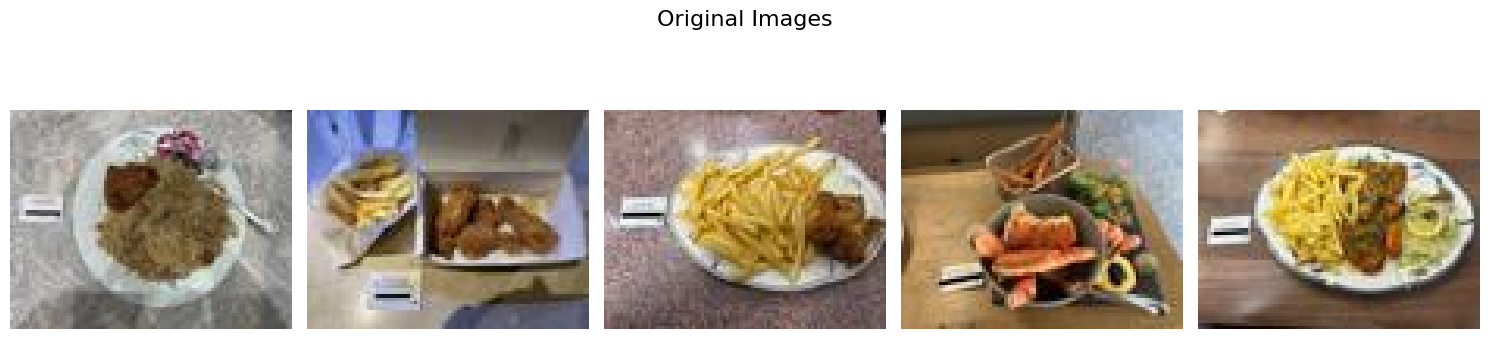

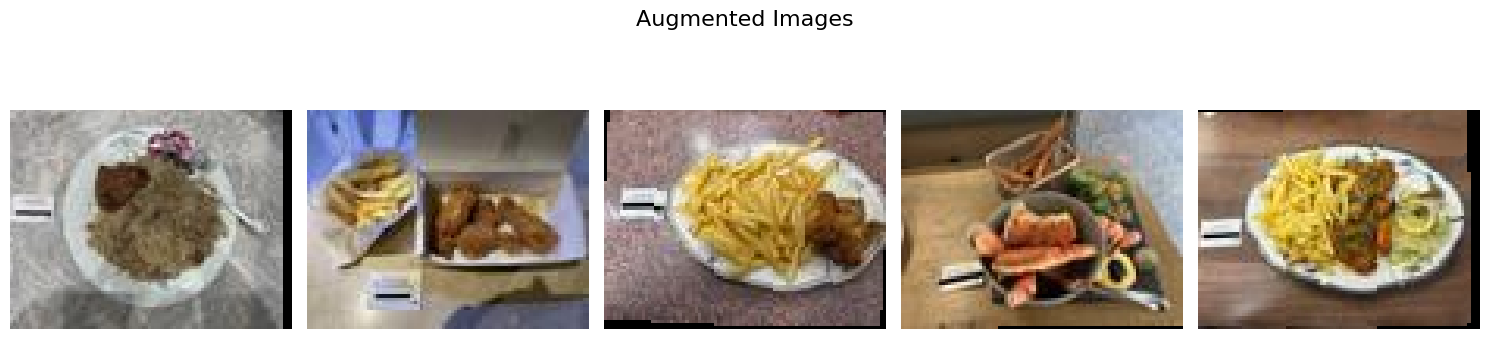

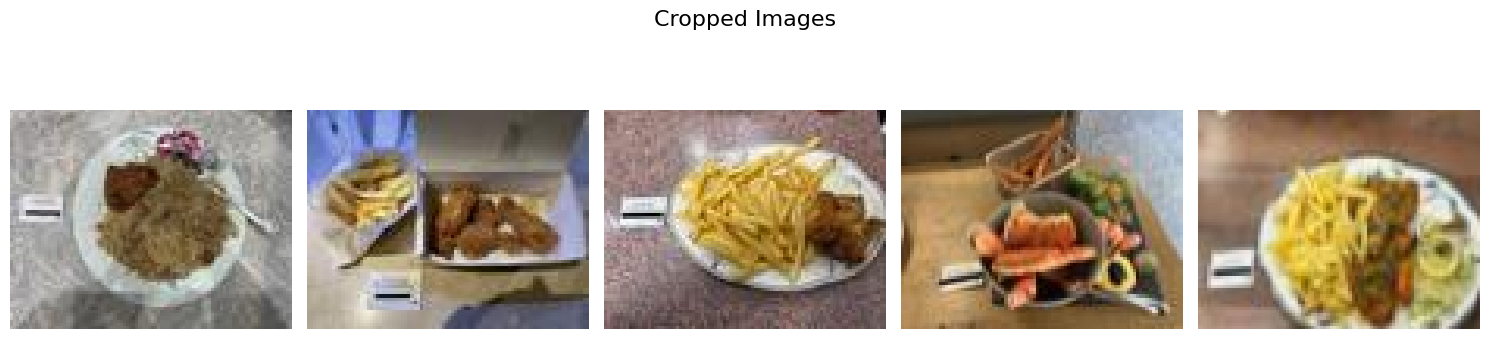

In [ ]:
import matplotlib.pyplot as plt

def plot_images(images, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 4))
    fig.suptitle(title, fontsize=16)
    for i in range(5):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

sample_indices =random.sample(range(len(origin_X_train)), 5)
original_samples = origin_X_train[sample_indices]
augmented_samples = augmented_X_train_array[sample_indices]
cropped_samples = cropped_before_flatten[sample_indices]

plot_images(original_samples, 'Original Images')
plot_images(augmented_samples, 'Augmented Images')
plot_images(cropped_samples, 'Cropped Images')


# G. Results

### Cross-validation

The table below displays the cross-validation outcomes for the best-performing model, showcasing a range of evaluated metric scores across multiple experiments.The purpose of multiple experiemnts through cross-validation is to optimise the model's performance, ensure the model's stability before applying model to unseen test data.

| Experiment | Resizing | Data Augmentation | Feature Extration | Best Model| Accuracy| Precision|Recall|F1|
|----------|----------|----------|----------|----------|----------|----------|----------|----------|
| A   | (90,70)  | No   |-   |LR   |0.725000  |0.758095 | 0.750000 |0.750826|
| B   | (90,90)   | No   |-   |LR   |0.711667 |0.735873 |0.750000 | 0.739061|
| C   | (90,70)   | Yes(Simple) - combined   |-   |SVM   |0.631855 |0.658658	 |0.732680 | 0.690491	|
| D   | (90,70)   | No  |-   |GridSearch - SVC(poly,degree=2)   |	0.712500 |0.744762 |0.750000 | 0.743808	|
|E   | (90,70)   | No  |Yes(food separation)   |LR   |	0.468333 |0.522727 |0.536111 | 0.524733	|


Experiment B tests the concept of **resizing images into a square shape**, which is commonly practiced. Additionally, exploring slightly larger image sizes, from (90,70) to (90,90), might help the model's ability to make accurate classifications.

Experiment C used **the combined dataset of original + data augmentation** applied version of the dataset. There is a potential risk of overfitting, but I experimented on combined dataset to increase the diversity of the dataset which can contribute to the enhanced peformance. However, this data augmentation rather decreased the metrics score.

Experiment D is the result of **'Hyperparameter tuning**' experiment using the GridSearchCV to find the best parameter with the best performance. I first tried to find the optimal hyperparameter 'C' to Logistic Regression model, but the best parameter suggested by GridSearch didn't show the increase in cross-validation score . On the other hand, SVM showed big improvement in overall scores after changing kernel to 'poly' with degree=2.

In [ ]:
# Experiment D. GridSearchCV experiment code
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid_svm = [
    {'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]},
    {'kernel': ['poly'], 'C': [0.001, 0.01, 0.1, 1, 10], 'degree': [2, 3, 4]},
    {'kernel': ['sigmoid'], 'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
]

svm = SVC(random_state=42)

gs_svm = GridSearchCV(svm, param_grid_svm, cv=5)
gs_svm.fit(origin_X_train_flattened, y_train)

best_params_svm = gs_svm.best_params_
print("Best Parameters of SVM:", best_params_svm)


Best Parameters of SVM: {'C': 1, 'degree': 2, 'kernel': 'poly'}


Experiment E was conducted using training data that had undergone cropping with the separate_food function, which utilizes saturation-based food separation. The observed performance was lower than anticipated, indicating a potential limitation in the ability of the separate_food function to successfully crop image areas relevant to rice/chips classification.

### Apply Best performing case to Test data - Experiment A: In-depth Analysis

[ Test the model ]


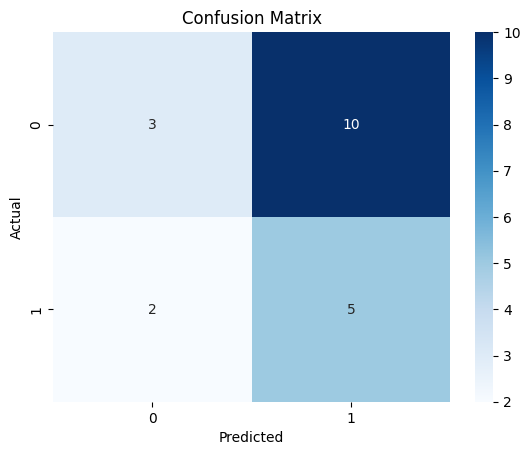

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

results = model_evaluation(model, origin_X_train_flattened, y_train, origin_X_test_flattened, y_test,True) # Set to Test mode
cm = confusion_matrix(y_test, results['y_pred'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
metrics = ['Accuracy_test', 'Precision_test', 'Recall_test', 'F1 Score_test']
selected_results = {key: results[key] for key in metrics}

# Create a DataFrame
results_df = pd.DataFrame.from_dict(selected_results, orient='index', columns=['score'])
print(results_df)

                   score
Accuracy_test   0.400000
Precision_test  0.333333
Recall_test     0.714286
F1 Score_test   0.454545


FP Analysis

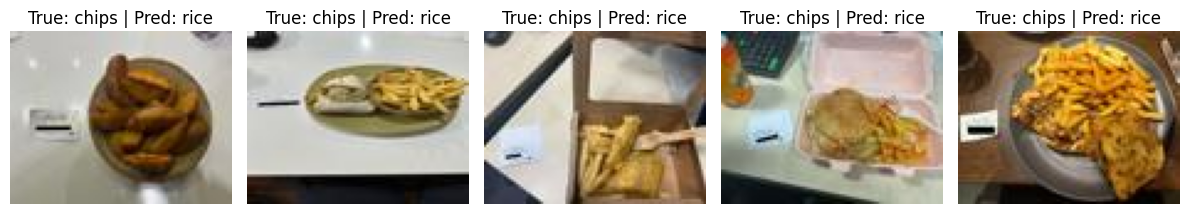

In [ ]:
# Visualize False Positives
y_pred = results['y_pred']
FP = np.where((y_test != y_pred) & (y_pred == 1))[0]
FN = np.where((y_test != y_pred) & (y_pred == 0))[0]

classes = ['chips', 'rice']
plt.figure(figsize=(12, 6))

# Visualize False Positives
num_cols = min(len(FP), 5)  # Limited to 5 for visualisation
num_rows = (len(FP) // num_cols) + 1

for i in range(min(len(FP), 5)):
    plt.subplot(num_rows, num_cols, i + 1)
    img_index = FP[i]
    img = Image.open(resize_dir + X_test.iloc[img_index][0])
    plt.title(f'True: {classes[y_test[img_index]]} | Pred: {classes[y_pred[img_index]]}')
    plt.axis('off')
    plt.imshow(img)

plt.tight_layout()
plt.show()


FN Analysis

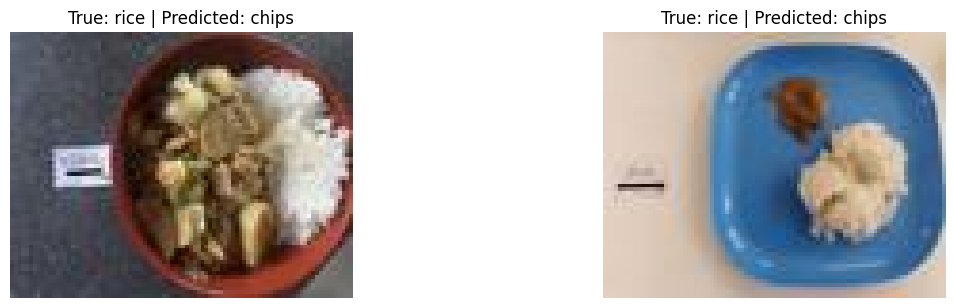

In [ ]:
plt.figure(figsize=(12, 6))
# Visualize False Negatives
num_cols = min(len(FN), 3)  # Limit to three columns for better layout
num_rows = (len(FN) // num_cols) + 1

for i in range(min(len(FN), 3)):
    plt.subplot(num_rows, num_cols, i + 1)
    img_index = FN[i]
    img = Image.open(resize_dir + X_test.iloc[img_index][0])
    plt.title(f'True: {classes[y_test[img_index]]} | Predicted: {classes[y_pred[img_index]]}')
    plt.axis('off')
    plt.imshow(img)

plt.tight_layout()
plt.show()


# H. Conclusions


Test Result Analysis


---


Based on the assessed scores, model's performance on test data shows notably lower precision and accuracy score. It has lower score than cross-validation score indicating the possibility of overfitting which lacks of robustness.

The confusion matrix highlights a higher count of False Positives (FP), indicating a tendency to misclassify 'chips' as 'rice'.

Visualized FP and FN plots suggest potential reasons for misclassification. Many FP instances exhibit a white background, possibly confusing the model as 'rice'. Yet, some clear chip images misclassified as 'rice' raising necessity of further investigation.


Interesting Insight

---



In this mini project, I conducted several experiments aimed at achieving optimal performance in classifying input images into a binary category of rice and chips, all without using deep learning models.

Logistic Regression model showed the best performance in the most of the experiment. Considering its simplicity and computational efficiency, it is interesting that linear separability applied well to this task.

The dataset augmented through techniques like data augmentation and cropping exhibited notably lower performance in comparison to the original dataset. This outcome hints at the potential loss of valuable information during the augmentation process, suggesting the introduction of unnecessary noise into the data.


Possible Improvements

---
- Food area Separation Improvement : Instead of using saturation based food area cropping, we can try to accurately detect the food area using pre-trained object detection model which is specialised in food detection.

- Use of CNN model: This may help accurately classify the images as it can take into considerations on patterns or visual features which can be critical on image classification.

- Improving data quality: One way of improving data quality can be image enhancement that can make the visual patterns more distinctive for the image classification task.

- Using larger dataset: This can be helpful to resolve the overfitting issue we have faced by making model to learn more diverse cases improving its robustness.

